# Exploration17 - 난 스케치를 할 테니 너는 채색을 하거라

Pix2Pix 학습을 통해 Segmentation Map으로부터 도로 이미지를 만들어 보자.

---

### 루브릭 평가 기준

1. pix2pix 모델 학습을 위한 데이터셋 구축 - 데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정을 제시하였나
2. pix2pix 모델을 구현하여 성공적인 학습 과정 진행 - U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였나
3. 학습 과정 및 테스트에 대한 시각화 결과 제출 - 10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞는 정도의 품질을 확인하였나

---

### 목차

0) 필요 모듈 import


1) 데이터 로드 및 전처리


2) Generator


3) Discriminator


4) 학습 진행 및 결과 확인


5) 회고

## 0. 필요 모듈 import

In [1]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

from tensorflow import data

from tensorflow.keras import layers, Input, Model

from tensorflow.keras import losses

from tensorflow.keras import optimizers

## 1. 데이터 로드 및 전처리

In [2]:
data_path = './data/cityscapes/'
train_path = data_path + 'train/'
test_path = data_path + 'val/'

print("number of train examples :", len(os.listdir(train_path)))
print("number of validation examples :", len(os.listdir(test_path)))

number of train examples : 1000
number of validation examples : 5


학습 데이터는 1000장, 검증 데이터는 5장으로 이루어진 데이터셋이다.

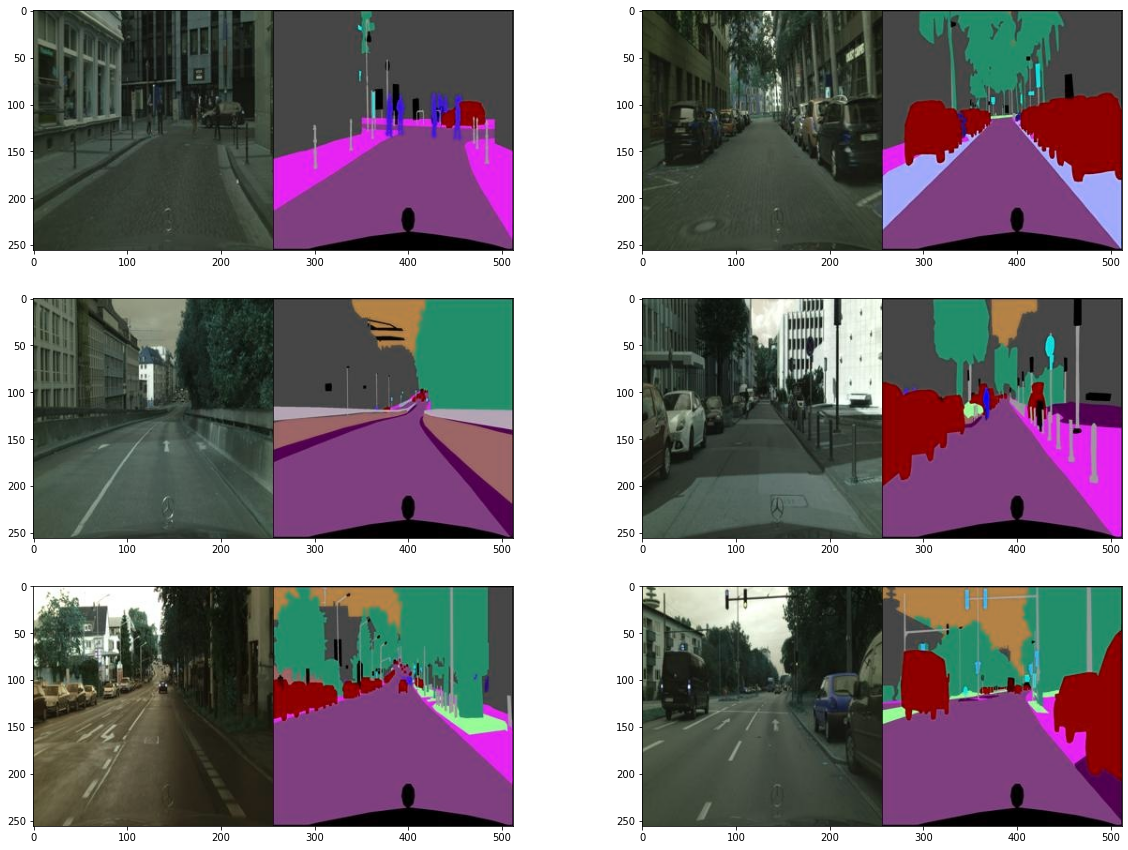

In [3]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = train_path + os.listdir(train_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

학습 데이터 중 무작위로 6장을 불러와 확인해보니, Segmentation Map과 Ground Truth가 하나의 이미지로 붙어있음을 알 수 있다.

In [4]:
f = train_path + os.listdir(train_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


shape을 확인해봐도 가로길이가 2배 더 긴것을 확인할 수 있다.  
이를 2장의 이미지로 나누어보자.

In [5]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    real_img = img[:, :w, :] 
    real_img = tf.cast(real_img, tf.float32)
    seg_map = img[:, w:, :] 
    seg_map = tf.cast(seg_map, tf.float32)
    return normalize(seg_map), normalize(real_img)

Text(0.5, 1.0, 'Ground Truth')

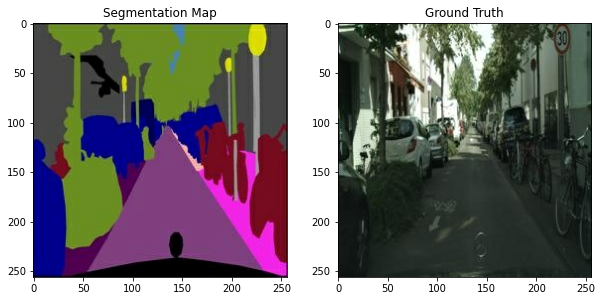

In [6]:
f = train_path + os.listdir(train_path)[1]
seg_map, real_img = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(seg_map)); plt.title('Segmentation Map')
plt.subplot(1,2,2); plt.imshow(denormalize(real_img)); plt.title('Ground Truth')

### - augmentation 적용

학습 데이터가 매우 적은편이므로 augmentation을 적용해 데이터의 다양성을 높여준다.

In [7]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용
def apply_augmentation(seg_map, real_img):
    stacked = tf.concat([seg_map, real_img], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

두 이미지를 채널축으로 묶어 동일한 처리를 해준다.  

- (256,256,6) 크기를 가진 이미지를 임의로 잘라낸다.
- 그 결과를 50% 확률로 가로로 뒤집는다.
- 그 결과를 50% 확률로 세로로 뒤집는다.
- 그 결과를 50% 확률로 회전시킨다.

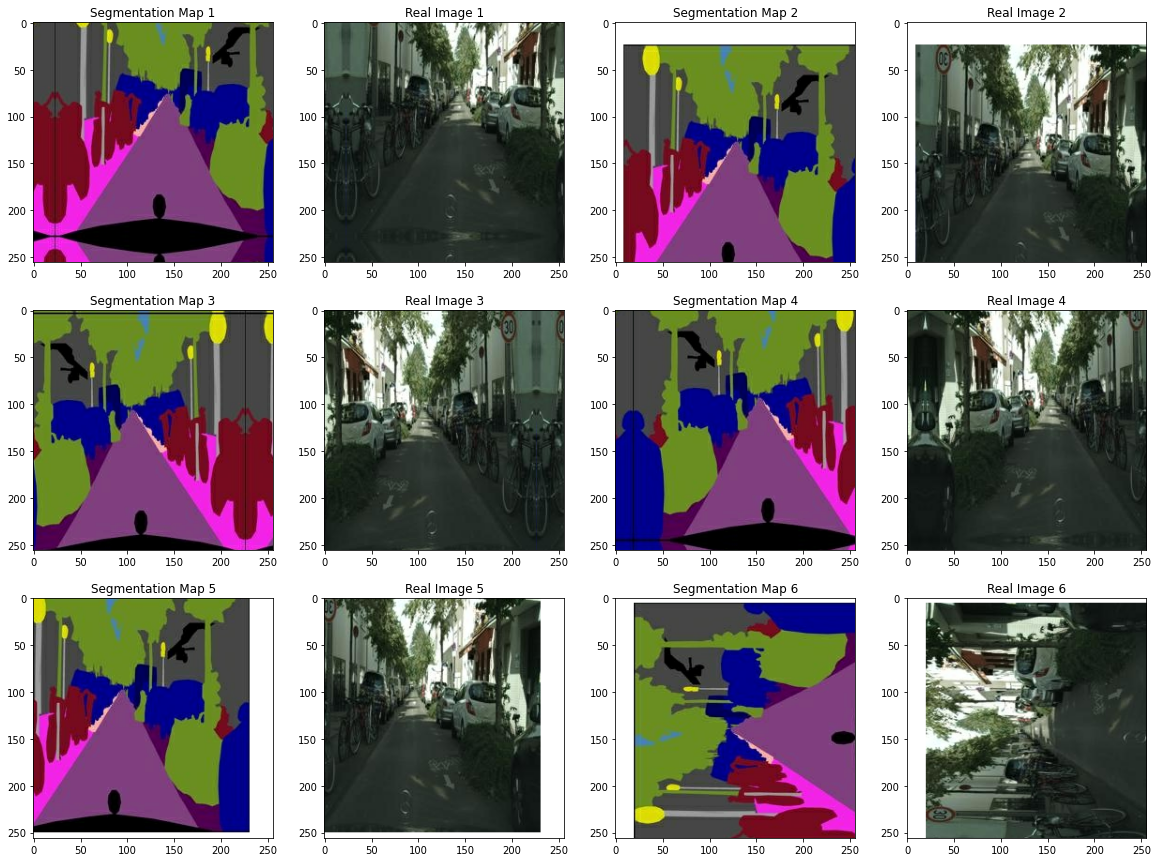

In [8]:
plt.figure(figsize=(20,15))
img_n = 1
for i in range(1, 13, 2):
    augmented_seg, augmented_real = apply_augmentation(seg_map, real_img)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_seg)); plt.title(f"Segmentation Map {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_real)); plt.title(f"Real Image {img_n}")
    img_n += 1

두 이미지에 동일한 처리가 적용되었음을 확인할 수 있다.  
학습 데이터에 전체적으로 적용을 해 보자.

In [9]:
def get_train(img_path):
    seg_map, real_img = load_img(img_path)
    seg_map, real_img = apply_augmentation(seg_map, real_img)
    return seg_map, real_img

train_images = data.Dataset.list_files(train_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
seg_map, real_img = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

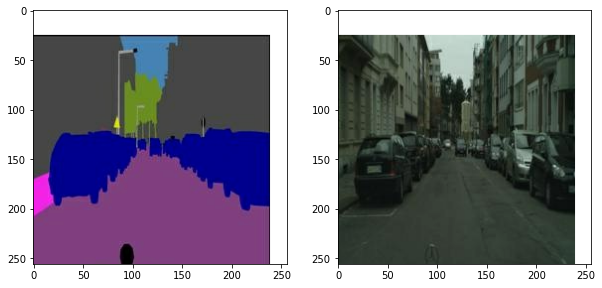

In [10]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(seg_map[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(real_img[0].astype(np.uint8))

## 2. Generator

U-Net 구조를 활용하여 생성자를 구현한다.

In [11]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [12]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [13]:
generator = UNetGenerator()
generator.get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

## 3. Discriminator

In [14]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [15]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [16]:
discriminator = Discriminator()
discriminator.get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

## 4. 학습 진행 및 결과 확인

10 epoch으로 학습을 진행하고 결과를 확인한다.

In [17]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [18]:
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

레이블 정보만 있는 입력에 대해 여러 손실 함수를 사용해 실제 이미지를 만들어 낸 결과는, 일반적인 GAN의 손실 함수에 L1을 추가로 이용했을 때 가장 실제에 가까운 이미지를 생성해 낸다.  
이번 프로젝트에서도 두 가지 손실 함수를 모두 사용한다.

In [19]:
# segmentation map이 input

@tf.function
def train_step(seg_map, real_img):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_img = generator(seg_map, training=True)
        # Discriminator 예측
        fake_disc = discriminator(seg_map, fake_img, training=True)
        real_disc = discriminator(seg_map, real_img, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_img, real_img, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [20]:
EPOCHS = 10

history = {'gen_loss':[], 'disc_loss':[], 'L1_loss':[]}

for epoch in range(1, EPOCHS+1):
    for i, (seg_map, real_img) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(seg_map, real_img)
        history['gen_loss'].append(g_loss)
        history['L1_loss'].append(l1_loss)
        history['disc_loss'].append(d_loss)
                
        # 50회 반복마다 손실을 출력합니다.
        if (i+1) % 50 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[50]                     
Generator_loss:1.1160                     
L1_loss:0.2314                     
Discriminator_loss:1.0436

EPOCH[1] - STEP[100]                     
Generator_loss:1.2441                     
L1_loss:0.1938                     
Discriminator_loss:0.7805

EPOCH[1] - STEP[150]                     
Generator_loss:0.6121                     
L1_loss:0.2244                     
Discriminator_loss:1.1879

EPOCH[1] - STEP[200]                     
Generator_loss:1.8980                     
L1_loss:0.2188                     
Discriminator_loss:0.7093

EPOCH[1] - STEP[250]                     
Generator_loss:1.1475                     
L1_loss:0.1632                     
Discriminator_loss:1.3192

EPOCH[2] - STEP[50]                     
Generator_loss:2.3575                     
L1_loss:0.1761                     
Discriminator_loss:0.6351

EPOCH[2] - STEP[100]                     
Generator_loss:3.8013                     
L1_loss:0.1740               

### - Loss 시각화

Text(0.5, 0, 'batch iters')

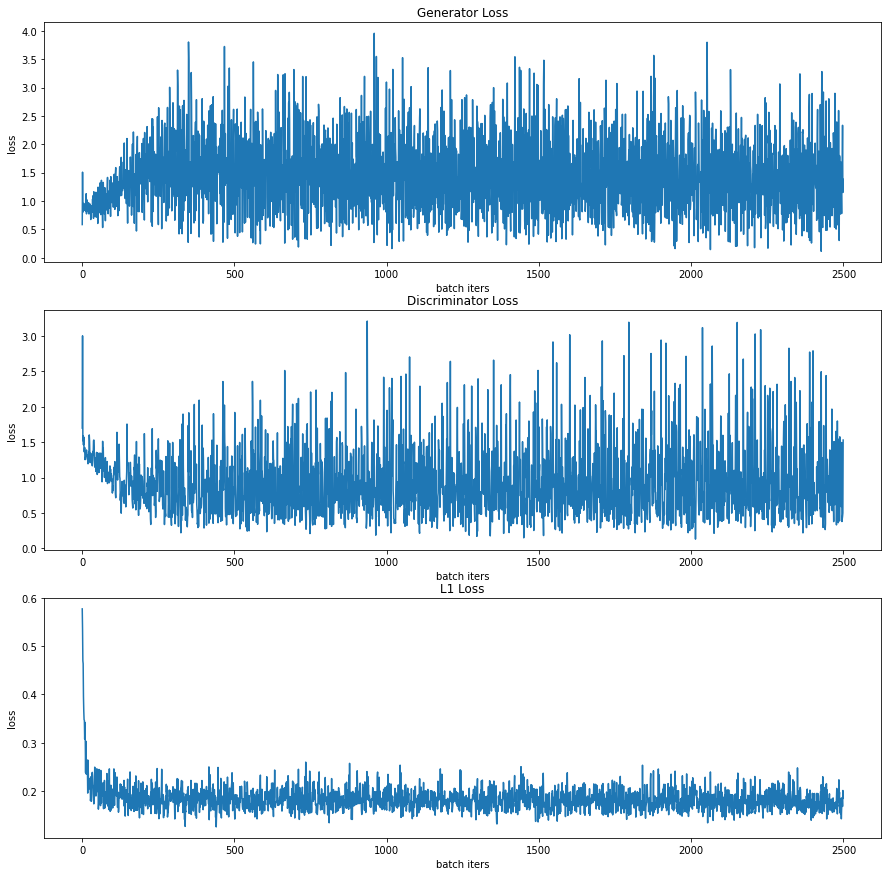

In [21]:
plt.figure(figsize=(15,15))

plt.subplot(311)  
plt.plot(history['gen_loss'])  
plt.title('Generator Loss')  
plt.ylabel('loss')  
plt.xlabel('batch iters')  

plt.subplot(312)  
plt.plot(history['disc_loss'])  
plt.title('Discriminator Loss')  
plt.ylabel('loss')  
plt.xlabel('batch iters')  

plt.subplot(313)  
plt.plot(history['L1_loss'])   
plt.title('L1 Loss')  
plt.ylabel('loss')  
plt.xlabel('batch iters')  

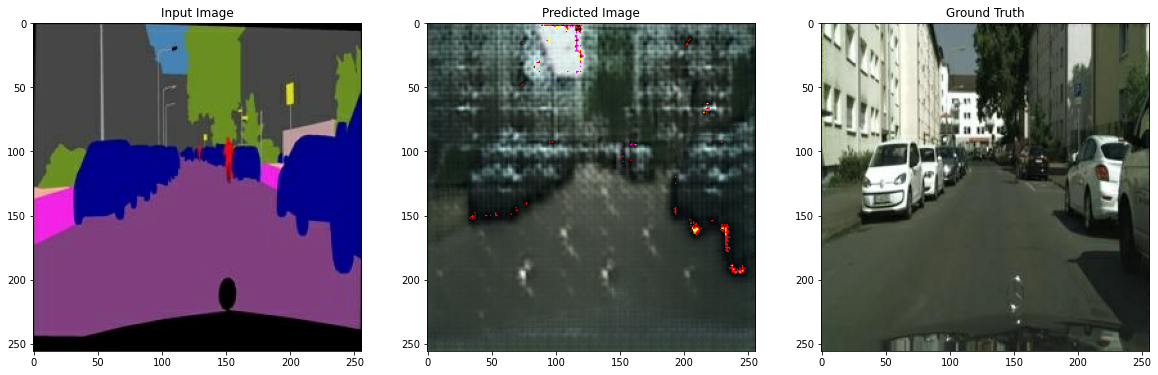

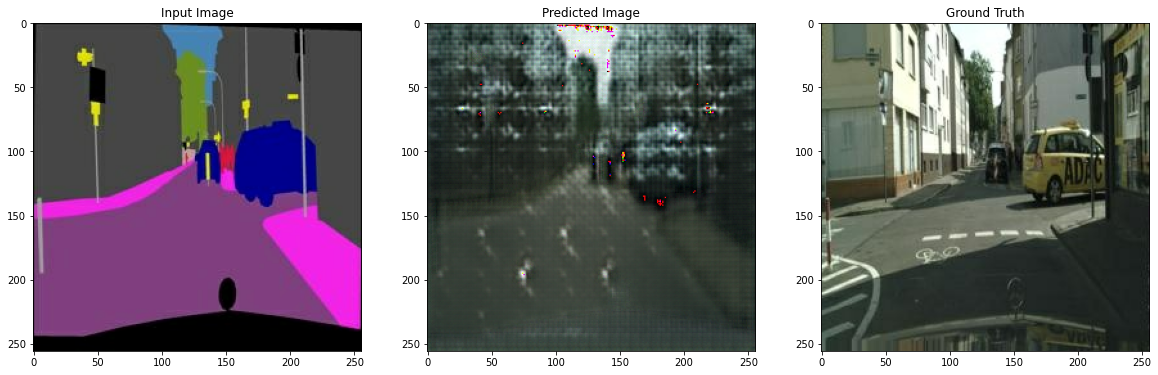

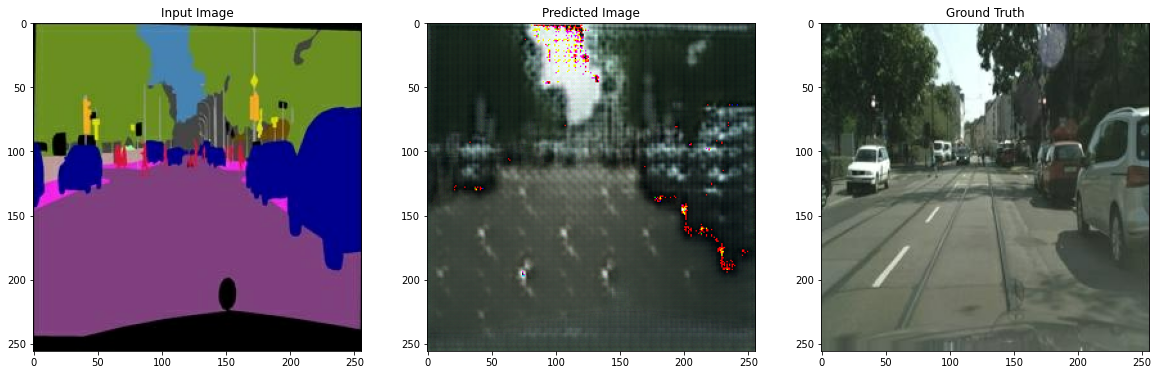

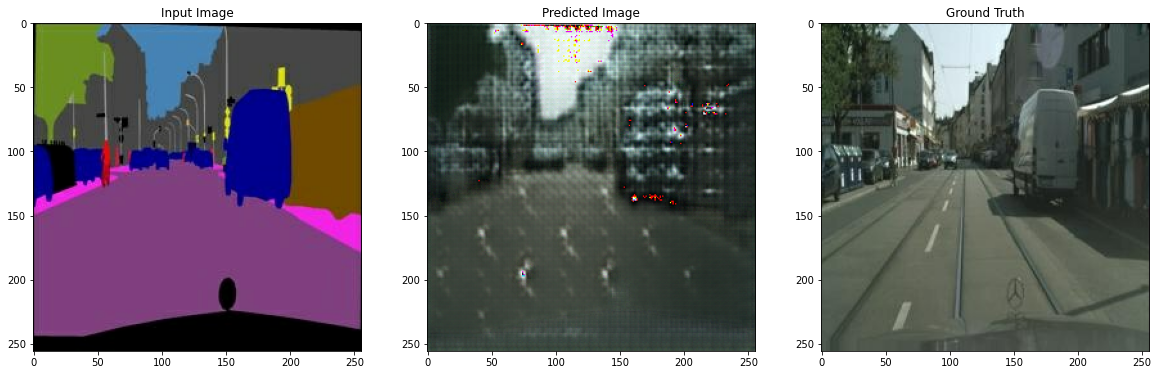

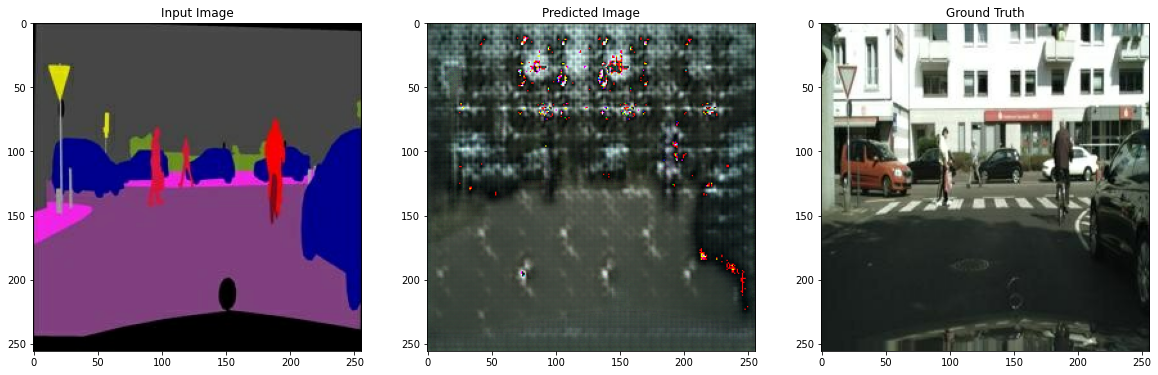

In [22]:
for i in range(5):
    f = test_path + os.listdir(test_path)[i]
    seg_map, real_img = load_img(f)
    
    pred = generator(tf.expand_dims(seg_map, 0))
    pred = denormalize(pred)
    
    plt.figure(figsize=(20,15))
    plt.subplot(1,3,1); plt.imshow(denormalize(seg_map)); plt.title('Input Image')
    plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image')
    plt.subplot(1,3,3); plt.imshow(denormalize(real_img)); plt.title('Ground Truth')

완벽하게 실제 이미지와 유사한 결과를 내놓기에는 epoch 수가 너무 적었다는 생각이 든다.  
학습을 더 많이 시킨다면 실제와 비슷한 이미지를 내놓을 수 있을 것 같다.

## 5. 회고

#### - Input이 뭐라고??

처음에 학습을 진행할 때, input이미지가 segmentation map이라는 사실을 인지하지 못해서 엉뚱한 결과를 봤었다.  
그 이후 어떤 것이 입력데이터인지 인지를 했지만 데이터를 분리하는 과정에서도 순서가 헷갈려 또 잘못된 결과를 봤다.  
이런 시행착오를 겪으며 시간을 너무 많이 잡아먹어 더 많은 학습을 진행하지 못햇다는 점에서 아쉬움이 많이 남는다.  